In [1]:
import os
from scapy.all import rdpcap
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from scapy.utils import rdpcap
from scapy.layers.inet import IP, TCP, UDP

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scapy.utils import rdpcap
from scapy.layers.inet import IP, TCP, UDP

# Path to the folder containing the PCAP files
DATA_FOLDER = "PCAPFiles"

# Function to parse PCAP files and extract relevant features
def parse_pcap_files(data_folder):
    files = [f for f in os.listdir(data_folder) if f.endswith('.pcap')]
    dataframes = []

    for file in files:
        file_path = os.path.join(data_folder, file)
        print(f"Processing {file_path}...")
        packets = rdpcap(file_path)
        rows = []

        for packet in packets:
            if IP in packet:
                row = {
                    'src_ip': packet[IP].src,
                    'dst_ip': packet[IP].dst,
                    'src_port': packet[TCP].sport if TCP in packet else (packet[UDP].sport if UDP in packet else None),
                    'dst_port': packet[TCP].dport if TCP in packet else (packet[UDP].dport if UDP in packet else None),
                    'protocol': packet[IP].proto,
                    'packet_length': len(packet)
                }
                rows.append(row)

        df = pd.DataFrame(rows)
        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)

# Parse the PCAP files into a DataFrame
data = parse_pcap_files(DATA_FOLDER)

# Explore the data structure
print("Data Columns:", data.columns)
print("Sample Rows:")
print(data.head())

Processing PCAPFiles\Friday-WorkingHours.pcap...


In [4]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [13]:
data.columns = data.columns.str.strip() 
X = data.drop(columns=['Label'])  # Features
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)  # Replace NaN with column means
y = data['Label']  # Target labels
# Encode the target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Preprocessing the data
# Handle missing values and prepare features
data['src_port'] = data['src_port'].fillna(-1).astype(int)
data['dst_port'] = data['dst_port'].fillna(-1).astype(int)
data['protocol'] = data['protocol'].astype(int)
data['packet_length'] = data['packet_length'].astype(int)

# For now, generate dummy labels for testing purposes (replace with actual labels logic)
data['Label'] = 'BENIGN'  # Update this with your labeling logic

# Prepare features and labels
X = data.drop(columns=['Label', 'src_ip', 'dst_ip'])  # Features
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)  # Replace NaN with column means
y = data['Label']  # Target labels

# Encode the target labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [25]:
# Build a Neural Network with TensorFlow
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='sigmoid', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='swish'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='swish'),
    tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='relu')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               10112     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 15)               

In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Add early stopping and learning rate scheduler callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  
    patience=3,  # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6  # Minimum learning rate
)

# Train the model
print("Training the neural network with early stopping and learning rate scheduler...")
history = model.fit(
    X_train, 
    y_train, 
    epochs=100,  # Set a high number of epochs; early stopping will prevent overtraining
    batch_size=128, 
    validation_split=0.2, 
    verbose=2, 
    callbacks=[early_stopping, reduce_lr]
)

Training the neural network with early stopping and learning rate scheduler...
Epoch 1/100
14154/14154 - 81s - loss: 2.6309 - accuracy: 0.8046 - val_loss: 2.7080 - val_accuracy: 0.8036 - lr: 0.0010 - 81s/epoch - 6ms/step
Epoch 2/100
14154/14154 - 95s - loss: 2.7083 - accuracy: 0.8029 - val_loss: 2.7080 - val_accuracy: 0.8036 - lr: 0.0010 - 95s/epoch - 7ms/step
Epoch 3/100
14154/14154 - 93s - loss: 2.7083 - accuracy: 0.8029 - val_loss: 2.7080 - val_accuracy: 0.8036 - lr: 0.0010 - 93s/epoch - 7ms/step
Epoch 4/100
14154/14154 - 76s - loss: 2.7083 - accuracy: 0.8029 - val_loss: 2.7080 - val_accuracy: 0.8036 - lr: 0.0010 - 76s/epoch - 5ms/step
Epoch 5/100
14154/14154 - 64s - loss: 2.7083 - accuracy: 0.8029 - val_loss: 2.7080 - val_accuracy: 0.8036 - lr: 2.0000e-04 - 64s/epoch - 5ms/step
Epoch 6/100
14154/14154 - 76s - loss: 2.7083 - accuracy: 0.8029 - val_loss: 2.7080 - val_accuracy: 0.8036 - lr: 2.0000e-04 - 76s/epoch - 5ms/step


In [20]:
# Evaluate the model
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {accuracy}")

Evaluating the model...
17693/17693 - 33s - loss: 2.7080 - accuracy: 0.8027 - 33s/epoch - 2ms/step
Test Accuracy: 0.8026756048202515


In [21]:
# Generate predictions and classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

17693/17693 [==============================] - 21s 1ms/step
Classification Report:


c:\Users\kaleb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kaleb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kaleb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

                            precision    recall  f1-score   support

                    BENIGN       0.80      1.00      0.89    454434
                       Bot       0.00      0.00      0.00       390
                      DDoS       0.00      0.00      0.00     25583
             DoS GoldenEye       0.00      0.00      0.00      2074
                  DoS Hulk       0.00      0.00      0.00     46486
          DoS Slowhttptest       0.00      0.00      0.00      1072
             DoS slowloris       0.00      0.00      0.00      1173
               FTP-Patator       0.00      0.00      0.00      1612
                Heartbleed       0.00      0.00      0.00         2
              Infiltration       0.00      0.00      0.00         5
                  PortScan       0.00      0.00      0.00     31711
               SSH-Patator       0.00      0.00      0.00      1173
  Web Attack � Brute Force       0.00      0.00      0.00       308
Web Attack � Sql Injection       0.00      0.00

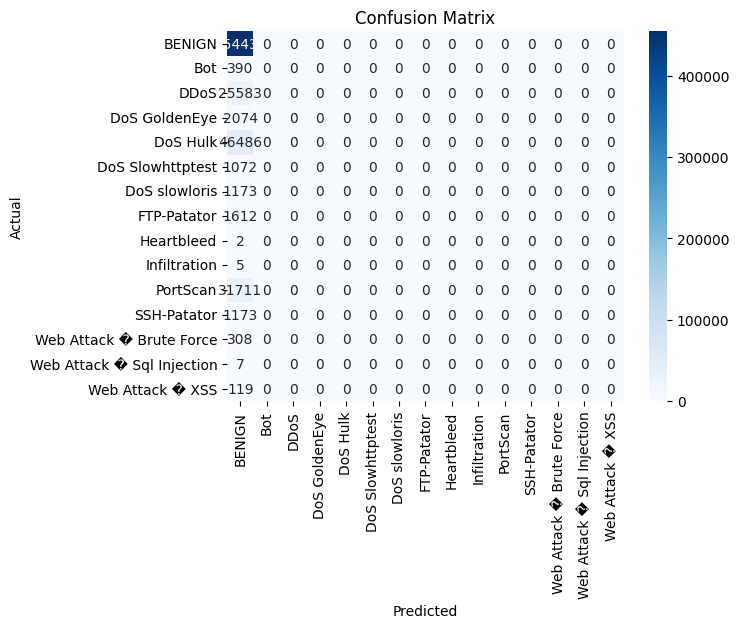

In [22]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Save the trained model
model.save('Internship Project/neural_network_model')
print("Neural network model saved to 'Internship Project/neural_network_model'")

INFO:tensorflow:Assets written to: Internship Project/neural_network_model\assets
Neural network model saved to 'Internship Project/neural_network_model'


In [24]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [27]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights_dict = dict(enumerate(class_weights))



# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add early stopping and learning rate scheduler callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  
    patience=3,  # Number of epochs with no improvement before reducing the learning rate
    min_lr=1e-6  # Minimum learning rate
)

# Train the model with class weights
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    verbose=2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]  # Include your callbacks
)


Epoch 1/100


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
# Evaluate the model
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {accuracy}")

In [ ]:
# Generate predictions and classification report
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model
model.save('Internship Project/neural_network_model')
print("Neural network model saved to 'Internship Project/neural_network_model'")